# Approach 1 :Convex optimisation lib

**1&nbsp;&nbsp;[Introduction](#1)**  
**2&nbsp;&nbsp;[Environment](#2)**  
&nbsp;&nbsp;&nbsp;&nbsp;2.1&nbsp;&nbsp;[Libraries](#2.1)  
&nbsp;&nbsp;&nbsp;&nbsp;2.2&nbsp;&nbsp;[Data](#2.2)  
**3&nbsp;&nbsp;[Optimisation](#3)**  
&nbsp;&nbsp;&nbsp;&nbsp;3.1&nbsp;&nbsp;[Constants, parameters and variables](#3.1)  
&nbsp;&nbsp;&nbsp;&nbsp;3.2&nbsp;&nbsp;[Objective function](#3.2)  
&nbsp;&nbsp;&nbsp;&nbsp;3.3&nbsp;&nbsp;[Constraints](#3.3)  
&nbsp;&nbsp;&nbsp;&nbsp;3.4&nbsp;&nbsp;[Solution](#3.4)  
**4&nbsp;&nbsp;[Evaluation](#4)**  
&nbsp;&nbsp;&nbsp;&nbsp;4.1&nbsp;&nbsp;[Parameterised portfolio](#4.1)  
&nbsp;&nbsp;&nbsp;&nbsp;4.2&nbsp;&nbsp;[Optimal portfolio](#4.2)  
**5&nbsp;&nbsp;[Conclusion](#5)**

## 1 Introduction<a id="1"></a>

Given a set of $n$ assets:
* $\mathbf{p} \in \mathbb{R}_+^n$ is the price vector where $p_i$ is the price of asset $i$.
* $\mathbf{x} \in \mathbb{Z}^n$ is the portfolio allocation vector where $x_i$ is the number of shares in asset $i$ to buy. To prevent shorting: $\mathbf{x}\geq0$.
* In one time period, $\mathbf{r} \in \mathbb{R}^n$ is the return vector where $r_i$ is the return on asset $i$. The return is the difference in price divided by the price at the beginning of the period: $r_i = \frac{p_{t+1}-p_t}{p_t}$. Portfolio return $R$ is given by: $R = \mathbf{r}^T\mathbf{x}$.
* The return vector $\mathbf{r}$ can be modelled as a random variable with mean $\mathbb{E}[\mathbf{r}]=\mathbf{\mu}$ and covariance $\mathbb{E}[(\mathbf{r}-\mathbf{\mu})(\mathbf{r}-\mathbf{\mu})^T]=\Sigma$. It follows that the portfolio return is also a random variable with mean $\mathbb{E}[R]=\mathbf{\mu}^T\mathbf{x}$ and variance $\mathrm{Var}[R]=\mathbf{x}^T\Sigma\mathbf{x}$.
* $k \in \mathbb{R}_+^n$ is the maximum amount in one asset.

The optimal portfolio allocation is found by maximising the expected portfolio fractional return and minimising the portfolio variance. This becomes a mixed-integer quadratic programming problem:
$$\mathrm{arg}\max_{\mathbf{x}} \mathbf{\mu}^T\mathbf{x}-\frac{1}{2} \mathbf{x}^T\Sigma\mathbf{x}$$
$$\mathrm{subject\ to}$$
$$\mathbf{x} \in \mathbb{Z}^n$$
$$\mathbf{x}\geq0$$
$$p_i\mathbf{x} \leq k$$

An equivalent optimisation problem is to set an upper bound $\sigma^2$ on the portfolio variance and maximise the expected portfolio fractional return:
$$\mathrm{arg}\max_{\mathbf{x}} \mathbf{\mu}^T\mathbf{x}$$
$$\mathrm{subject\ to}$$
$$\mathbf{x} \in \mathbb{Z}^n$$
$$\mathbf{x}\geq0$$
$$\mathbf{x}^T\Sigma\mathbf{x} \leq \sigma^2$$
$$p_i\mathbf{x}\leq k$$

## 2 Environment<a id="2"></a>

### 2.1 Libraries<a id="2.1"></a>

Load libraries into notebook

In [133]:
import os                               # Operating system
import math                             # Mathematics
import numpy as np                      # Arrays
import pandas as pd                     # Dataframes
import matplotlib.pyplot as plt         # Graphs
from matplotlib import cm               # Colours
import scipy                            # Scientific computing
import cvxpy as cp                      # Convex optimisation
from mpl_toolkits.mplot3d import Axes3D # 3D graphs

In [134]:
%matplotlib inline

### 2.2 Data<a id="2.2"></a>

Get list of stock names

In [135]:
stocks = [stock.split('.')[0] for stock in sorted(os.listdir(r'C:\Users\utkar\Desktop\Python\IIT\MOM\NIFTY DATA'))]

In [136]:
stocks

['NIFTY AUTO',
 'NIFTY BANK',
 'NIFTY FIN SERVICE',
 'NIFTY FMCG',
 'NIFTY IT',
 'NIFTY MEDIA',
 'NIFTY METAL',
 'NIFTY PHARMA',
 'NIFTY PSU BANK',
 'NIFTY PVT BANK']

Create a dataframe containing dates

In [137]:
dates = pd.date_range('2015-01-01', '2020-03-31') # Create date range from 01-01-2000 to 31-03-2020
data = pd.DataFrame({'Time': dates})              # Add dates to dataframe with column name

Append the adjusted closing price of each stock to a dataframe keyed on date

In [138]:
for stock in stocks:                                                          # For each stock
    prices = pd.read_csv(                                                     # Read prices into dataframe
        r'C:\Users\utkar\Desktop\Python\IIT\MOM\NIFTY DATA\\' + stock + '.csv', # Get filename
        usecols=['Date', 'Close']                                         # Select date and adjusted closing price
    )
    prices['Date'] = pd.to_datetime(prices['Date'])                           # Typecast dates to datetimes
    prices.rename(                                                            # Rename columns
        columns={"Date": "Time", "Close": stock},
        inplace=True
    )
    data = pd.merge(                                                          # Add stock to master dataframe
        data,                                                                 # Initially contains dates only
        prices,                                                               # Insert stock prices
        how='left',                                                           # Left outer join
        on=['Time'],                                                          # Key on the time column
        sort=False
    )

In [139]:
data

,Time,NIFTY AUTO,NIFTY BANK,NIFTY FIN SERVICE,NIFTY FMCG,NIFTY IT,NIFTY MEDIA,NIFTY METAL,NIFTY PHARMA,NIFTY PSU BANK,NIFTY PVT BANK
0,2015-01-01,8318.80,18750.45,7449.95,20057.60,11215.70,2378.3,2693.25,10923.25,4294.65,9673.20
1,2015-01-02,8365.40,19057.80,7611.70,20142.65,11372.10,2382.1,2715.45,10955.60,4311.65,9848.38
2,2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,8467.95,19017.40,7575.25,20184.85,11248.55,2376.3,2704.50,10920.60,4281.15,9836.21
...,...,...,...,...,...,...,...,...,...,...,...
1912,2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913,2020-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914,2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1915,2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
data = data.dropna(how='any',axis=0)

In [141]:
data

,Time,NIFTY AUTO,NIFTY BANK,NIFTY FIN SERVICE,NIFTY FMCG,NIFTY IT,NIFTY MEDIA,NIFTY METAL,NIFTY PHARMA,NIFTY PSU BANK,NIFTY PVT BANK
0,2015-01-01,8318.80,18750.45,7449.95,20057.60,11215.70,2378.30,2693.25,10923.25,4294.65,9673.20
1,2015-01-02,8365.40,19057.80,7611.70,20142.65,11372.10,2382.10,2715.45,10955.60,4311.65,9848.38
4,2015-01-05,8467.95,19017.40,7575.25,20184.85,11248.55,2376.30,2704.50,10920.60,4281.15,9836.21
5,2015-01-06,8248.20,18430.75,7309.55,19863.35,10959.90,2294.70,2610.45,10637.80,4104.60,9568.34
6,2015-01-07,8254.70,18304.25,7263.80,19841.10,10916.00,2275.70,2568.65,10604.95,4091.60,9518.55
...,...,...,...,...,...,...,...,...,...,...,...
1831,2020-01-06,7978.75,31237.15,14202.50,29799.30,15879.80,1717.35,2765.75,7987.35,2414.65,17298.90
1832,2020-01-07,8002.50,31399.40,14314.75,29861.80,15895.20,1735.15,2785.90,8036.50,2416.65,17384.50
1833,2020-01-08,7942.75,31373.65,14306.65,29893.20,15953.45,1726.60,2767.25,7996.15,2401.85,17371.35
1834,2020-01-09,8155.25,32092.40,14590.10,30123.60,15925.15,1767.95,2806.80,8033.15,2459.85,17760.50


Remove non-trading days

In [142]:
# data = data[data['Time'].dt.weekday < 5] # Remove weekend dates
# data = data.dropna(axis=0, how='all') # Remove empty rows

## 3 Optimisation<a id="3"></a>

### 3.1 Constants, parameters and variables<a id="3.1"></a>

Get last price for each stock

In [143]:
p = data \
    .drop(['Time'], axis=1) \
    .tail(1) \
    .to_numpy()

In [144]:
p

array([[ 8225.5 , 32097.4 , 14609.65, 30370.45, 15959.9 ,  1770.65,
         2840.75,  8058.5 ,  2461.4 , 17729.25]])

Calculate weekly returns from 1 January 2015 onwards

In [145]:
r = data[(data['Time'].dt.weekday == 4) & (data['Time'] >= '2015-01-01')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')

In [146]:
r

,NIFTY AUTO,NIFTY BANK,NIFTY FIN SERVICE,NIFTY FMCG,NIFTY IT,NIFTY MEDIA,NIFTY METAL,NIFTY PHARMA,NIFTY PSU BANK,NIFTY PVT BANK
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.003777,-0.022067,-0.028916,0.007149,0.002423,-0.044268,-0.042847,-0.001921,-0.040112,-0.012890
15,0.026986,0.031437,0.041358,0.033665,0.022803,0.055828,-0.039591,0.015236,0.029550,0.031373
22,0.041688,0.044194,0.045341,-0.010749,0.019345,0.002163,0.042725,0.043234,0.028491,0.046959
29,-0.005816,-0.011406,-0.007283,0.020321,-0.005082,-0.021420,-0.034405,0.009710,-0.076659,0.002295
...,...,...,...,...,...,...,...,...,...,...
1807,0.033702,0.021464,0.026250,-0.003609,-0.005824,-0.012141,0.035846,0.010996,0.044639,0.017853
1814,0.007912,0.011579,0.014944,-0.002297,0.042367,0.012516,0.030741,0.000547,0.000078,0.009384
1821,0.008895,0.000846,0.003661,-0.006947,-0.004030,0.015522,0.019520,0.002311,-0.000953,0.003053
1828,-0.004600,-0.010585,-0.008083,-0.001201,0.009879,-0.030321,0.031880,0.005441,-0.017189,-0.008785


Calculate expected return and covariance matrix

In [147]:
sigma = r.cov().to_numpy()
mu = r.mean().to_numpy()

In [148]:
mu

array([ 0.00030449,  0.00245743,  0.00295634,  0.00193053,  0.00164002,
       -0.00062829,  0.0007983 , -0.00081348, -0.00109225,  0.0027256 ])

In [149]:
sigma

array([[0.00074876, 0.00047643, 0.00045387, 0.00034507, 0.00015724,
        0.00054541, 0.00056479, 0.00035842, 0.00079372, 0.00046559],
       [0.00047643, 0.00065862, 0.0005956 , 0.00031575, 0.00014554,
        0.00044908, 0.00051964, 0.00030789, 0.00096391, 0.000643  ],
       [0.00045387, 0.0005956 , 0.00058739, 0.00031591, 0.00015074,
        0.00040688, 0.00046295, 0.0002752 , 0.00083358, 0.00058108],
       [0.00034507, 0.00031575, 0.00031591, 0.00050926, 0.00016932,
        0.00030756, 0.0003217 , 0.00022593, 0.00047374, 0.00030764],
       [0.00015724, 0.00014554, 0.00015074, 0.00016932, 0.00051288,
        0.0001516 , 0.00016759, 0.0001633 , 0.00013283, 0.00015314],
       [0.00054541, 0.00044908, 0.00040688, 0.00030756, 0.0001516 ,
        0.00115307, 0.00053164, 0.00041747, 0.00079791, 0.00043777],
       [0.00056479, 0.00051964, 0.00046295, 0.0003217 , 0.00016759,
        0.00053164, 0.00123319, 0.00038797, 0.00097555, 0.0004942 ],
       [0.00035842, 0.00030789, 0.0002752

Get number of stocks

In [150]:
n = len(stocks)

In [151]:
n

10

Set optimisation variable and parameters

In [152]:
x = cp.Variable(shape=n, integer=True)
threshold = cp.Parameter(nonneg=True) # maximum portfolio variance
k = cp.Parameter(nonneg=True) # maximum allocation into one stock

In [153]:
x

Variable((10,), integer=True)

In [154]:
x[0]

Expression(AFFINE, UNKNOWN, ())

In [155]:
threshold

Parameter((), nonneg=True)

In [156]:
k

Parameter((), nonneg=True)

Formulate portfolio mean and variance

In [157]:
mean = mu.T*x
variance = cp.quad_form(x, sigma)

C:\Users\utkar\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  warnings.warn(msg, UserWarning)


In [158]:
mean

Expression(AFFINE, UNKNOWN, ())

In [159]:
variance

Expression(CONVEX, NONNEGATIVE, (1, 1))

### 3.2 Objective function<a id="3.2"></a>

Define the objective function (maximise expected portfolio return)

In [160]:
objective = cp.Maximize(mean)

### 3.3 Constraints<a id="3.3"></a>

Define optimisation constraints

In [161]:
constraints = [
    x >= 0,                                 # no shorting
    variance <= threshold                   # upper bound on portfolio variance
]
for pi in p:
    constraints = constraints + [pi*x <= k] # upper bound on single-stock allocation

C:\Users\utkar\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)


In [162]:
constraints

[Inequality(Constant(CONSTANT, ZERO, ())),
 Inequality(Expression(CONVEX, NONNEGATIVE, (1, 1))),
 Inequality(Expression(AFFINE, UNKNOWN, ()))]

### 3.4 Solution<a id="3.4"></a>

Initialise the optimisation problem using objective function and constraints

In [163]:
problem = cp.Problem(objective, constraints)

Solve optimisation problem for each parameter combination

In [164]:
pip install cvxopt

Note: you may need to restart the kernel to use updated packages.


In [165]:
z_values = []
k_values = np.arange(1000, 5000, 1000)
threshold_values = np.arange(1, 5, 1)
for threshold_value in threshold_values:
    for k_value in k_values:
        threshold.value = threshold_value
        k.value = k_value
        problem.solve()
        if problem.status != 'optimal': continue
        counts = x.value.round()
        investments = p*counts
        returns = mu@investments[0]
        z_values.append(returns)

SolverError: Either candidate conic solvers (['GLPK_MI']) do not support the cones output by the problem (SOC, NonNeg), or there are not enough constraints in the problem.

## 4 Evaluation<a id="4"></a>

### 4.1 Parameterised return<a id="4.1"></a>

Plot expected portfolio return as a function of portfolio variance and maximum single-asset allocation

In [166]:
if len(z_values) == 0:
    print('No optimal solutions')
else:
    Z = np.reshape(z_values, (len(k_values), len(threshold_values)))
    figure = plt.figure(figsize = (12,10))
    axes = figure.add_subplot(111, projection='3d')
    for i in range(len(k_values))[::-1]:
        c = cm.jet(i/float(len(k_values)))
        axes.bar(
            threshold_values,
            Z[i,:],
            zs=k_values[i],
            zdir='y',
            width=0.4
        )
    axes.set_xlabel('Portfolio variance')
    axes.set_ylabel('Maximum single-asset allocation')
    axes.set_zlabel('Portfolio return')
    axes.set_title('Expected portfolio return vs. portfolio variance and maximum single-asset allocation')
    plt.show()

No optimal solutions


### 4.2 Optimal portfolio<a id="4.2"></a>

Calculate optimal portfolio using highest variance and maximum single-asset allocation

In [167]:
stocks_optimal = np.array(stocks)[np.where(counts > 0)]
counts_optimal = counts[counts>0]
prices_optimal = np.around(np.array(p), 2)[0][np.where(counts > 0)]
investments_optimal = np.around(investments, 2)[investments > 0]
capital_optimal = np.around(counts_optimal@prices_optimal, 2)
risk_optimal = np.around(counts.T@sigma@counts, 2)
return_optimal = np.around(52*returns/capital_optimal, 3)

NameError: name 'counts' is not defined

Print results

In [168]:
print('Stocks:\t\t', stocks_optimal)
print('Counts:\t\t', counts_optimal)
print('Prices:\t\t', prices_optimal)
print('Investments:\t', investments_optimal)
print('Capital:\t', capital_optimal)
print('Return:\t\t', return_optimal)
print('Risk:\t\t', risk_optimal)

NameError: name 'stocks_optimal' is not defined

## 5 Conclusion<a id="5"></a>

CSL and FPH, both growth companies in the Australian biotechnology sector, dominate the portfolio making up more than 80% of the total investment. While the expected portfolio return may have been maximised for a given portfolio variance based on historical price data, a more risk-averse portfolio will require further diversification. The expected return is based on past prices which is not a reasonable indicator of future performance.

# Approach 2: Monte carlo and  3 methods of SQP

# Monte Carlo Simulation

In [254]:
data_2 = data.copy()
data_2 = data_2.drop(['Time'],axis=1)

In [255]:
from finquant.portfolio import build_portfolio
#names = ['GOOG', 'AMZN', 'MCD', 'DIS']
# start_date = '2015-01-01'
# end_date = '2020-01-10'
pf = build_portfolio(data = data_2)

In [256]:
pf.properties()

----------------------------------------------------------------------
Stocks: NIFTY AUTO, NIFTY BANK, NIFTY FIN SERVICE, NIFTY FMCG, NIFTY IT, NIFTY MEDIA, NIFTY METAL, NIFTY PHARMA, NIFTY PSU BANK, NIFTY PVT BANK
Time window/frequency: 252
Risk free rate: 0.005
Portfolio Expected Return: 0.053
Portfolio Volatility: 0.155
Portfolio Sharpe Ratio: 0.312

Skewness:
   NIFTY AUTO  NIFTY BANK  NIFTY FIN SERVICE  NIFTY FMCG  NIFTY IT  \
0    0.301486    0.113508           0.346236    0.090765  0.550088   

   NIFTY MEDIA  NIFTY METAL  NIFTY PHARMA  NIFTY PSU BANK  NIFTY PVT BANK  
0     0.093018     0.021981      0.239453         0.04537        0.088948  

Kurtosis:
   NIFTY AUTO  NIFTY BANK  NIFTY FIN SERVICE  NIFTY FMCG  NIFTY IT  \
0   -1.135774   -1.222606          -0.992366   -1.509663  -1.24019   

   NIFTY MEDIA  NIFTY METAL  NIFTY PHARMA  NIFTY PSU BANK  NIFTY PVT BANK  
0    -0.908815     -0.81241     -0.948704       -0.070537       -1.351156  

Information:
   Allocation          

C:\Users\utkar\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


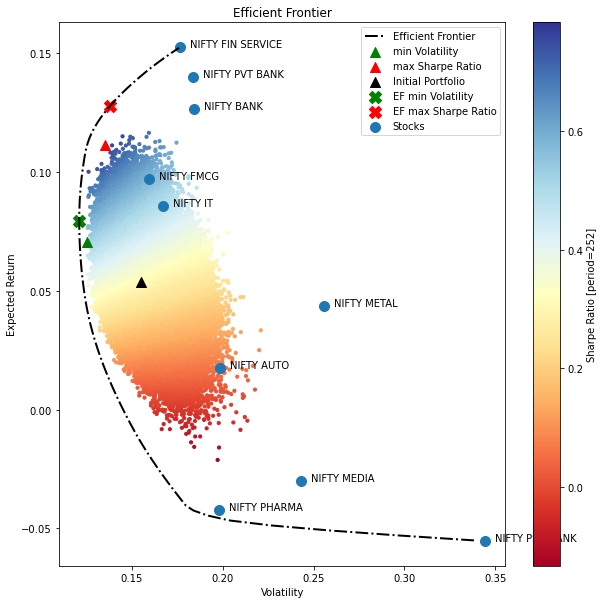

In [263]:
plt.figure(figsize=(10,10))

opt_w, opt_res = pf.mc_optimisation(num_trials=500000)
# plots the results of the Monte Carlo optimisation
pf.mc_plot_results()
# plots the Efficient Frontier
pf.ef_plot_efrontier()
# plots optimal portfolios based on Efficient Frontier
pf.ef.plot_optimal_portfolios()
# plots individual plots of the portfolio
pf.plot_stocks()

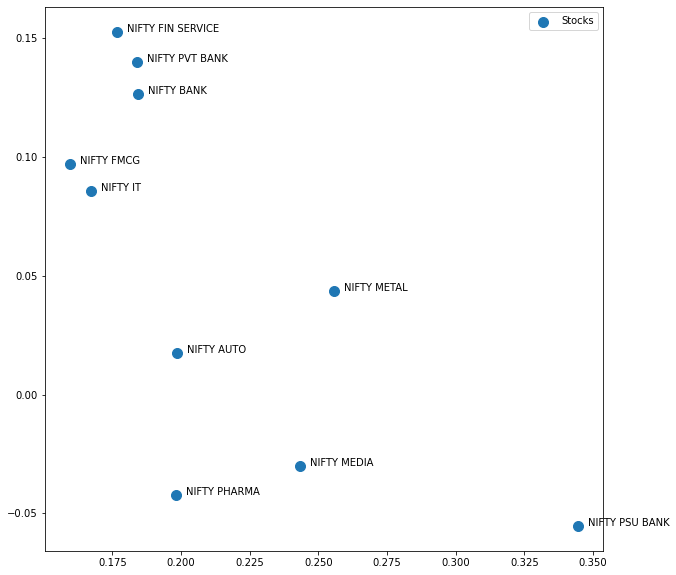

In [261]:
plt.figure(figsize=(10,10))

pf.plot_stocks()

# Optimum using constrained optimisation

##  Maximise Return with constraint on risk

In [219]:
pf = build_portfolio(data = data_2)

In [220]:
df = pf.ef_efficient_return(0.08)
df=df.reset_index()
df=df.rename({'index':'Name'}, axis=1)

In [221]:
df.round(2)

,Name,Allocation
0,NIFTY AUTO,0.00
1,NIFTY BANK,0.00
2,NIFTY FIN SERVICE,0.05
3,NIFTY FMCG,0.33
4,NIFTY IT,0.37
5,NIFTY MEDIA,0.00
6,NIFTY METAL,0.00
7,NIFTY PHARMA,0.14
8,NIFTY PSU BANK,0.00
9,NIFTY PVT BANK,0.11


In [223]:
pf = build_portfolio(data = data_2[['NIFTY FIN SERVICE','NIFTY FMCG','NIFTY IT','NIFTY PHARMA','NIFTY PVT BANK']])

In [224]:
df = pf.ef_efficient_return(0.1)
df=df.reset_index()
df=df.rename({'index':'Name'}, axis=1)
pf = build_portfolio(data=data_2, pf_allocation=df)
pf.properties()

----------------------------------------------------------------------
Stocks: NIFTY FIN SERVICE, NIFTY FMCG, NIFTY IT, NIFTY PHARMA, NIFTY PVT BANK
Time window/frequency: 252
Risk free rate: 0.005
Portfolio Expected Return: 0.100
Portfolio Volatility: 0.123
Portfolio Sharpe Ratio: 0.774

Skewness:
   NIFTY FIN SERVICE  NIFTY FMCG  NIFTY IT  NIFTY PHARMA  NIFTY PVT BANK
0           0.346236    0.090765  0.550088      0.239453        0.088948

Kurtosis:
   NIFTY FIN SERVICE  NIFTY FMCG  NIFTY IT  NIFTY PHARMA  NIFTY PVT BANK
0          -0.992366   -1.509663  -1.24019     -0.948704       -1.351156

Information:
   Allocation               Name
0    0.148608  NIFTY FIN SERVICE
1    0.337164         NIFTY FMCG
2    0.374937           NIFTY IT
3    0.038163       NIFTY PHARMA
4    0.101128     NIFTY PVT BANK
----------------------------------------------------------------------


In [225]:
df.round(2)

,Name,Allocation
0,NIFTY FIN SERVICE,0.15
1,NIFTY FMCG,0.34
2,NIFTY IT,0.37
3,NIFTY PHARMA,0.04
4,NIFTY PVT BANK,0.10


##  Minimise Risk with constraint on return

In [239]:
pf = build_portfolio(data = data_2)

In [248]:
df = pf.ef_efficient_volatility(0.16)
df=df.reset_index()
df=df.rename({'index':'Name'}, axis=1)

In [249]:
df.round(2)

,Name,Allocation
0,NIFTY AUTO,0.00
1,NIFTY BANK,0.00
2,NIFTY FIN SERVICE,0.86
3,NIFTY FMCG,0.00
4,NIFTY IT,0.14
5,NIFTY MEDIA,0.00
6,NIFTY METAL,0.00
7,NIFTY PHARMA,0.00
8,NIFTY PSU BANK,0.00
9,NIFTY PVT BANK,0.00


In [250]:
pf = build_portfolio(data = data_2[['NIFTY FIN SERVICE','NIFTY IT']])

In [251]:
df = pf.ef_efficient_volatility(0.1)
df=df.reset_index()
df=df.rename({'index':'Name'}, axis=1)
pf = build_portfolio(data=data_2, pf_allocation=df)
pf.properties()

----------------------------------------------------------------------
Stocks: NIFTY FIN SERVICE, NIFTY IT
Time window/frequency: 252
Risk free rate: 0.005
Portfolio Expected Return: 0.117
Portfolio Volatility: 0.136
Portfolio Sharpe Ratio: 0.823

Skewness:
   NIFTY FIN SERVICE  NIFTY IT
0           0.346236  0.550088

Kurtosis:
   NIFTY FIN SERVICE  NIFTY IT
0          -0.992366  -1.24019

Information:
   Allocation               Name
0     0.46905  NIFTY FIN SERVICE
1     0.53095           NIFTY IT
----------------------------------------------------------------------


In [252]:
df.round(2)

,Name,Allocation
0,NIFTY FIN SERVICE,0.47
1,NIFTY IT,0.53


## Sharpe Ratio

In [199]:
df = pf.ef_maximum_sharpe_ratio()
df=df.reset_index()
df=df.rename({'index':'Name'}, axis=1)

In [200]:
df.round(2)

,Name,Allocation
0,NIFTY AUTO,0.00
1,NIFTY BANK,0.00
2,NIFTY FIN SERVICE,0.60
3,NIFTY FMCG,0.15
4,NIFTY IT,0.25
5,NIFTY MEDIA,0.00
6,NIFTY METAL,0.00
7,NIFTY PHARMA,0.00
8,NIFTY PSU BANK,0.00
9,NIFTY PVT BANK,0.00


In [201]:
pf = build_portfolio(data = data_2[['NIFTY FIN SERVICE','NIFTY FMCG','NIFTY IT']])

In [202]:
df = pf.ef_maximum_sharpe_ratio()
df=df.reset_index()
df=df.rename({'index':'Name'}, axis=1)
pf = build_portfolio(data=data_2, pf_allocation=df)
pf.properties()

----------------------------------------------------------------------
Stocks: NIFTY FIN SERVICE, NIFTY FMCG, NIFTY IT
Time window/frequency: 252
Risk free rate: 0.005
Portfolio Expected Return: 0.127
Portfolio Volatility: 0.138
Portfolio Sharpe Ratio: 0.888

Skewness:
   NIFTY FIN SERVICE  NIFTY FMCG  NIFTY IT
0           0.346236    0.090765  0.550088

Kurtosis:
   NIFTY FIN SERVICE  NIFTY FMCG  NIFTY IT
0          -0.992366   -1.509663  -1.24019

Information:
   Allocation               Name
0    0.601467  NIFTY FIN SERVICE
1    0.146257         NIFTY FMCG
2    0.252276           NIFTY IT
----------------------------------------------------------------------


In [203]:
df.round(2)

,Name,Allocation
0,NIFTY FIN SERVICE,0.60
1,NIFTY FMCG,0.15
2,NIFTY IT,0.25
